# TRABAJO PRACTICO INVOP
### Consigna 1: Licitación

#### 🏫 Generación de datos
- [X] Generar **709 escuelas** con coordenadas en un rectángulo predefinido.
- [X] Crear un conjunto de **empresas ficticias** (A, B, C, ...).
- [X] Generar **tres instancias distintas** de ofertas de las empresas para las escuelas.

#### 📊 Modelos de licitación
- [X] Implementar el **modelo básico de licitación**.
- [ ] Ejecutar el modelo para **cada una de las tres instancias**.
- [ ] Implementar y correr el **modelo alternativo** que detecta si hay **más de un óptimo**.

#### 🧩 Unidades de Competencia (UC)
- [ ] Verificar que en **alguna instancia haya más de una empresa ganadora** en una misma UC.
- [ ] Seleccionar esa UC y **aplicar el algoritmo greedy de asignación** de escuelas dentro de ella.

#### 🧪 Validación y visualización
- [X] Visualizar la **geolocalización de las escuelas** en el plano.
- [ ] Mostrar los **resultados de las licitaciones** y las **empresas ganadoras**.
- [ ] Analizar y comentar los **casos con múltiples óptimos**.


In [2]:
# SIGUIENTES PASOS
# EJECUTAR PARA LAS OTRAS 2 - hay que agregar que tmb busquen la segunda mejor sol
# ESCRIBIR INFORME
# poner lindo...


In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from pyscipopt import Model

np.random.seed(1902+209+703)

## Creamos las funciones

In [4]:
# Subproblema: Construir las clases de equivalencia - J_i y I_j

def son_equivalentes(i,j,B):
    return (B[i,:]==B[j,:]).all()
        

def extraer_clases_equivalencias(B):
    clases_equivalencias=[]
    sin_ofertantes=[]
    empresas_participantes=[]
    areas_donde_participan=[[] for i in range (B.shape[1])]
    for i in range(B.shape[0]):
        lo_meti=False
        #Separamos las escuelas sin ofertantes
        if (B[i,:]==np.zeros_like(B[i,:])).all():
            sin_ofertantes.append(i)
            lo_meti=True

        j=0 #Nos fijamos en las distintas clases de equivalencias que ya definimos si i pertenece a alguna clase de equivalencia ya definida
        
        while j<len(clases_equivalencias) and not lo_meti :
            representante=clases_equivalencias[j][0]
            if son_equivalentes(i,representante,B):
                clases_equivalencias[j].append(i)
                
                lo_meti=True
            j+=1
        if not lo_meti:
            clases_equivalencias.append([i])
            
            #J_i
            aux=[]
            for ind in range(B.shape[1]):
                if B[i,ind]==1:
                    aux.append(ind)
                    #se va computando mientras se crea clases de equivalencia
                    areas_donde_participan[ind].append(len(clases_equivalencias)-1)
            empresas_participantes.append(aux)
            
    return clases_equivalencias, sin_ofertantes, empresas_participantes, areas_donde_participan


In [5]:
# función que va a crear el modelo a minimizar
def definir_modelo(B,costos,nombre_modelo,T_max,T_min):
    model=Model(nombre_modelo)
    M=B.shape[0]
    num_empresas=B.shape[1]
    J, sin_ofertantes, I_j, J_i = extraer_clases_equivalencias(B)
    x=np.empty([num_empresas,len(J)],dtype="object")
    y=np.empty([num_empresas,len(T_max)],dtype="object")
    z=np.empty([num_empresas,len(T_max)],dtype="object")
    for i in range(num_empresas):
        for j in range(len(J)):
            #(11)
            x[i,j]=model.addVar(name=f"x_{i}_{j}",vtype="I")
            
        for t in range(len(T_max)):
            #(12)
            y[i,t]=model.addVar(name=f"y_{i}_{t}",vtype="B")
            #(13)
            z[i,t]= model.addVar(name=f"z_{i}_{t}",vtype="I")

    #(5)
    model.setObjective(sum(costos[i,t]*z[i,t] for i in range(num_empresas) for t in range(len(T_max))),"minimize")

    #(6)
    for j in range(len(J)):
        model.addCons(sum(x[i,j] for i in I_j[j]) ==len(J[j]))

    
    for i in range(num_empresas):
        #(9)
        model.addCons(sum(y[i,t] for t in range(len(T_max))) == 1)

        for t in range(len(T_max)):
            #(7)
            model.addCons(sum(x[i,j] for j in J_i[i]) >= T_min[t] - M*(1-y[i,t])) 
            #(8)
            model.addCons(sum(x[i,j] for j in J_i[i]) <= T_max[t] + M*(1-y[i,t]))
            #(10)
            model.addCons(sum(x[i,j] for j in J_i[i])-M*(1-y[i,t]) <= z[i,t])
    
    return model, sin_ofertantes

In [6]:
# definimos la funcion que calcula el segundo óptimo
def obtener_optimos_alternativos(B,costos,modelo_anterior,solucion_previa,T_max,T_min):
    model=Model()
    M=B.shape[0]
    num_empresas=B.shape[1]
    J, sin_ofertantes, I_j, J_i = extraer_clases_equivalencias(B)
    x=np.empty([num_empresas,len(J)],dtype="object")
    y=np.empty([num_empresas,len(T_max)],dtype="object")
    z=np.empty([num_empresas,len(T_max)],dtype="object")
    for i in range(num_empresas):
        for j in range(len(J)):
            #(11)
            x[i,j]=model.addVar(name=f"x_{i}_{j}",vtype="I")
            
        for t in range(len(T_max)):
            #(12)
            y[i,t]=model.addVar(name=f"y_{i}_{t}",vtype="B")
            #(13)
            z[i,t]= model.addVar(name=f"z_{i}_{t}",vtype="I")

    #(5)
    model.setObjective(sum(costos[i,t]*z[i,t] for i in range(num_empresas) for t in range(len(T_max))),"minimize")

    #(6)
    for j in range(len(J)):
        model.addCons(sum(x[i,j] for i in I_j[j]) ==len(J[j]))

    
    for i in range(num_empresas):
        #(9)
        model.addCons(sum(y[i,t] for t in range(len(T_max))) == 1)

        for t in range(len(T_max)):
            #(7)
            model.addCons(sum(x[i,j] for j in J_i[i]) >= T_min[t] - M*(1-y[i,t])) 
            #(8)
            model.addCons(sum(x[i,j] for j in J_i[i]) <= T_max[t] + M*(1-y[i,t]))
            #(10)
            model.addCons(sum(x[i,j] for j in J_i[i])-M*(1-y[i,t]) <= z[i,t])
    
   ##############################################################################################
    J_I_validos=[]
    a={}
    M=B.shape[0]
    for v in modelo_anterior.getVars():
        if v.name[0]=="x" and solucion_previa[v] != 0:
            aux=v.name.split("_") #separo los numeros [x,i,j]
            J_I_validos.append((int(aux[-1]),int(aux[1])))
            a[int(aux[-1]),int(aux[1])]=solucion_previa[v]        
    #Creamos almacenamiento de las nuevas variables
    w={}
    w_prima={}
    #añadimos las variables al modelo
    for j, i in J_I_validos:
        w[j,i]=model.addVar(name=f"w_{j}_{i}",vtype="B")
        w_prima[j,i]=model.addVar(name=f"w_prima_{j}_{i}",vtype="B")

    #añadimos las constrains para bloquear la solucion anterior
    for j,i in J_I_validos:

        model.addCons(x[i,j]>= (a[j,i]+1)*w[j,i])

        model.addCons(M - x[i,j] >= (M - (a[j,i] - 1)) * w_prima[j,i])

    model.addCons(sum(w[j,i]+w_prima[j,i] for j, i in J_I_validos)>=1)


    return model, sin_ofertantes

In [7]:
# para analizar la solución
def filtrar_variables_ganadores(model,solucion):
    reparto={}
    for v in model.getVars():
        if v.name[0]=="x" and solucion[v] != 0:
            aux=v.name.split("_") #separo los numeros [x,i,j]
            reparto[int(aux[1]),int(aux[-1])]=solucion[v]
    return reparto

In [124]:
#plotear distribución en una unidad de reparto
def plot_UC(escuelas,J,numero_unidad,reparto):
    
    #obtenemos las empresas relevantes
    keys=[]
    for i, j in reparto.keys():
        if j==numero_unidad:
            keys.append((i,j))
    
    #obtenemos las escuelas relevantes
    unidad_competencia=J[numero_unidad]
    escuelas_uc=escuelas[unidad_competencia]
    sorted_escuelas_uc=np.array(sorted(escuelas_uc,key= lambda x:(-x[1],x[0]))) #dejamos primero los puntos mas arriba a la izquierda
    c = []
    for i,j in keys: 
        c+=[str(i)]*round(reparto[i,j])
    
    df = pd.DataFrame(sorted_escuelas_uc, columns=['x', 'y'])
    df['empresa'] = c
    
    ax = sn.scatterplot(data = df, x ='x', y='y', hue='empresa', palette='tab10')
    ax.legend(bbox_to_anchor=(1.05, 1), 
              loc='upper left')
    ax.set_title(f"Asignación de las escuelas en la unidad de competencia {j}")
    plt.tight_layout()

In [125]:
# plot todas las escuelas, coloreadas según la empresa a la que le compra el internet
def plot_reparto(escuelas, J, reparto, sin_oferta, title=""):
    df = pd.DataFrame(escuelas[sin_oferta], columns=['x', 'y'])
    df['Unidad de competencia'] = 'Sin oferta'

    for numero_unidad in range(len(J)):
        #obtenemos las empresas relevantes
        keys=[]
        for i, j in reparto.keys():
            if j==numero_unidad:
                keys.append((i,j))
    
        #obtenemos las escuelas relevantes
        unidad_competencia=J[numero_unidad]
        escuelas_uc=escuelas[unidad_competencia]
        sorted_escuelas_uc=np.array(sorted(escuelas_uc,key= lambda x:(-x[1],x[0]))) #dejamos primero los puntos mas arriba a la izquierda
        
        empresas = []
        for i,j in keys: 
            empresas += [str(i)]*round(reparto[i,j]) # agrego la etiqueta que refiere a la empresa i la cantidad de veces que deba aparecer

        datos_uc = pd.DataFrame(sorted_escuelas_uc, columns=['x', 'y'])
        datos_uc['empresa'] = empresas

        df = pd.concat([df, datos_uc], ignore_index=True)
            
    ax = sn.scatterplot(data = df, x ='x', y='y', hue='empresa', palette='tab10')
    ax.legend(bbox_to_anchor=(1.05, 1), 
              loc='upper left')
    ax.set_title(title)
    plt.tight_layout()


In [126]:
def plot_unidades_competencia(escuelas, J, sin_oferta):
    df = pd.DataFrame()

    for j in range(len(J)):
        datos = pd.DataFrame(escuelas[J[j]], columns=['x','y'])
        datos['Unidad de competencia'] = j
        df = pd.concat([df, datos], ignore_index=True)

    ax = sn.scatterplot(data=df, x='x', y='y', hue='Unidad de competencia', palette='tab10')
    ax.scatter(escuelas[sin_oferta][:,0], escuelas[sin_oferta][:,1], c='black', marker='X', label = 'Sin oferta')
    ax.legend(bbox_to_anchor=(1.05, 1), 
              loc='upper left')
    ax.set_title("Unidades de competencia")
    plt.tight_layout()

In [152]:
def plot_ofertas_de_empresa(escuelas, B, i):
    df = pd.DataFrame(escuelas[B[:, i] == 1], columns=['x','y'])

    ax = sn.scatterplot(data=df, x='x', y='y')
    ax.set_title(f"Escuelas sobre las que ofertó la empresa {i}")
    plt.tight_layout()
    plt.show()

## Creamos los modelos

Primero creamos la distribución de las escuelas

Text(0.5, 1.0, 'Escuelas')

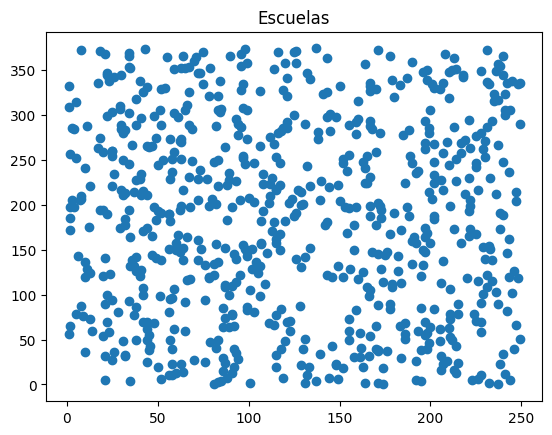

In [118]:
#Creamos el mapa y las escuelas
num_escuelas=709
diametro=250

escuelas_x = np.random.randint(0,diametro, num_escuelas)
escuelas_y = np.random.randint(0,1.5*diametro,num_escuelas)
escuelas=np.array([escuelas_x,escuelas_y]).T
plt.scatter(escuelas[:,0],escuelas[:,1])
plt.title("Escuelas")

Creamos el conjunto de empresas y sus ofertas, para las tres simulaciones.

Con esta información, creamos las unidades de competencia.

In [83]:
#Creamos un conjunto de empresas
#Creamos su conjunto de escuelas en las que oferta - para las 3 simulaciones

num_empresas=4 # Con 5 y 4 me exploto el kernel, sacando el alternativo

B1 = np.random.randint(0, 2, size=(num_escuelas, num_empresas)) 
B2 = np.random.randint(0, 2, size=(num_escuelas, num_empresas)) 
B3 = np.random.randint(0, 2, size=(num_escuelas, num_empresas)) 

J1, sin_of, I_j ,J_i=extraer_clases_equivalencias(B1)  # sin_of = lista de escuelas donde nadie ofertó
J2, sin_of_2, I_j_2 ,J_i_2=extraer_clases_equivalencias(B2)
J3, sin_of_3, I_j_3 ,J_i_3=extraer_clases_equivalencias(B3)

In [145]:
B1 #escuelas x empresas

array([[0, 1, 1, 0],
       [1, 1, 1, 0],
       [0, 1, 0, 1],
       ...,
       [0, 0, 0, 1],
       [1, 1, 0, 1],
       [1, 0, 1, 0]])

Decidimos los rangos de precios de las distintas empresas

## Solucionamos las simulaciones

### Caso 1:

Primero definimos los precios por intervalo
        

In [85]:
T_min=list(range(0,100,20))+list(range(100,200,50))+list(range(200,701,100))
T_max= [T_min[i]-1 for i in range(1,len(T_min))]+[709]
costos=np.zeros([num_empresas,len(T_max)])

for i in range(num_empresas):
    costos[i,0]=np.random.rand()*1000 + 400
    for t in range(1,len(T_max)):
        descuento=1-(np.random.rand()/10)
        costos[i,t]= costos[i,t-1] * descuento
        

In [86]:
costos # vemos los costos definidos

array([[ 665.8947792 ,  599.87576538,  582.33958816,  531.07672451,
         497.295953  ,  471.44582798,  469.85464274,  466.84759512,
         444.66868564,  400.35692594,  388.92875969,  381.9373253 ,
         375.66089333],
       [1379.72091911, 1351.79254066, 1275.97763702, 1165.51221504,
        1086.82834982, 1041.79721626,  940.71307675,  876.0876974 ,
         809.53152723,  761.72759139,  687.33490177,  684.42717105,
         654.06117604],
       [1308.57344459, 1288.90968903, 1262.41980527, 1212.93759516,
        1183.50878947, 1130.85036993, 1097.64512796, 1076.02396339,
        1040.47873457,  936.58077815,  925.51906871,  899.36184867,
         815.177578  ],
       [1030.33579243,  992.95456627,  961.03404209,  960.8341334 ,
         877.48481102,  839.78512113,  796.74200278,  790.99454925,
         768.0921807 ,  705.49799614,  694.99758205,  663.50306728,
         640.76832069]])

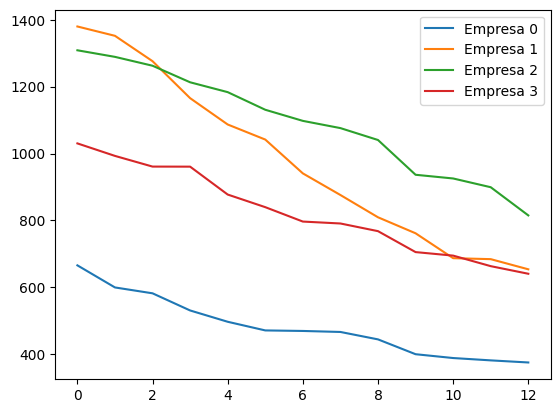

In [87]:
# comparamos los precios para las distintas empresas en distintos rangos
for i in range(num_empresas):
    plt.plot(range(0,len(T_max)),costos[i], label=f"Empresa {i}")
plt.legend()

Luego, veamos las unidades de competencia definidas

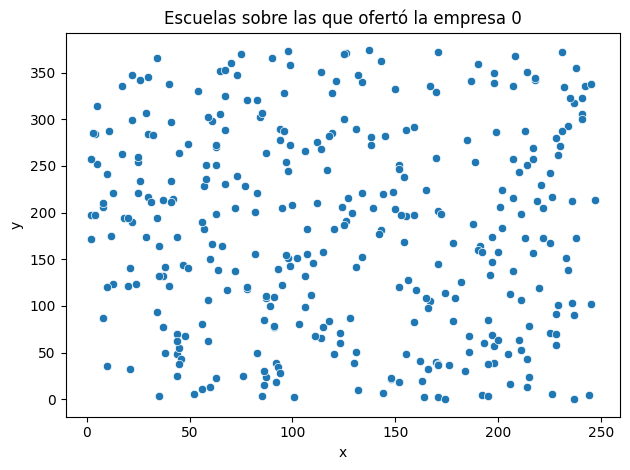

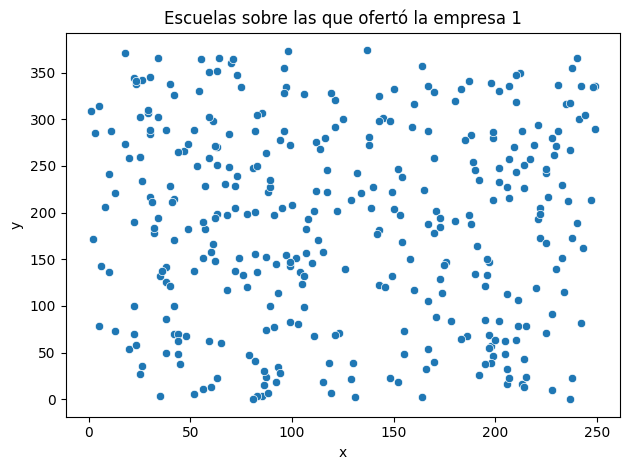

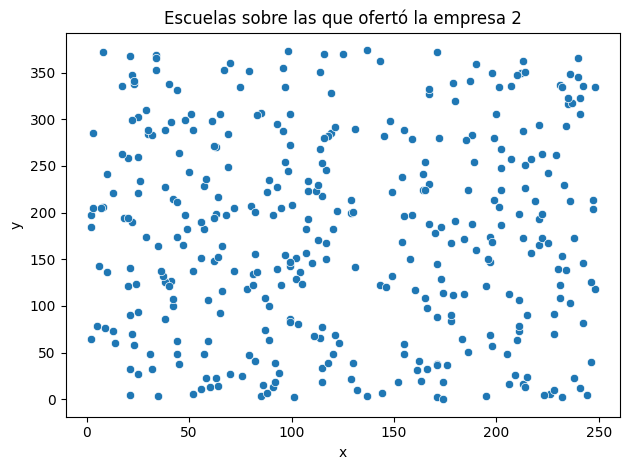

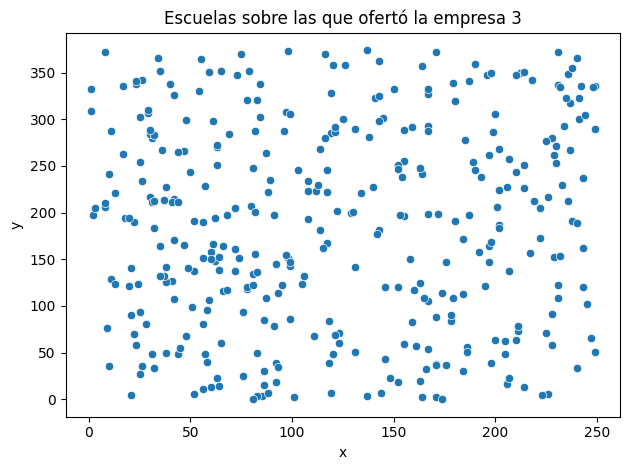

In [154]:
for i in range(num_empresas):
    plot_ofertas_de_empresa(escuelas, B1, i)

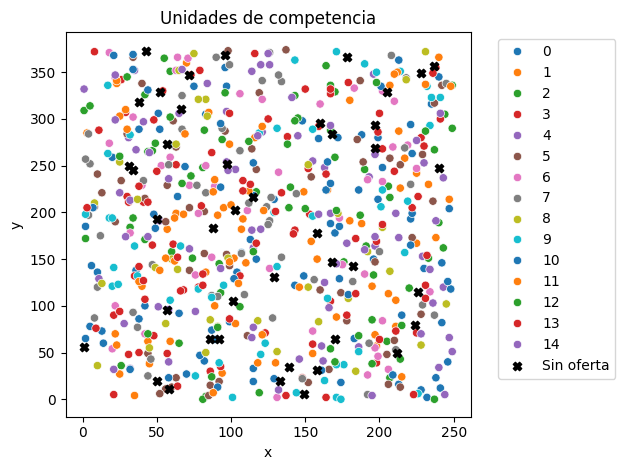

In [127]:
plot_unidades_competencia(escuelas, J1, sin_of)

Creamos el modelo y lo resolvemos. Nos fijamos si existe una solución alternativa

In [128]:
model, sin_ofertantes = definir_modelo(B1,costos,nombre_modelo="Licitacion",T_max=T_max,T_min=T_min)

In [129]:
# obtenemos la solución
#model.redirectOutput()
model.optimize()
sol=model.getBestSol()
model.writeSol(sol,"solve1.xlsx")
valor_optimo=model.getObjVal()

In [130]:
modelo_alternativo, sin_ofertantes_alternativo = obtener_optimos_alternativos(B1,costos,model,sol,T_max=T_max,T_min=T_min)

Comparamos las soluciones

In [131]:
#modelo_alternativo.redirectOutput()
modelo_alternativo.optimize()
if round(modelo_alternativo.getObjVal(), 2) == round(valor_optimo, 2):
    sol_alternativa=modelo_alternativo.getBestSol()
    modelo_alternativo.writeSol(sol,"solve1_alt.xlsx")
else:
    print("No hay otra solución óptima.")
    sol_alternativa = None

In [132]:
modelo_alternativo.getObjVal() , valor_optimo

(454593.6329199465, 454593.63291994657)

In [133]:
reparto=filtrar_variables_ganadores(model,sol)
print("Reparto de escuelas original")
print(reparto)

if sol_alternativa is not None:
    reparto_alt=filtrar_variables_ganadores(modelo_alternativo,sol_alternativa)
    print()
    print("Reparto de escuelas alternativo")
    print(reparto_alt)
else:
    print("No hay solución alternativa")
    reparto_alt = None

Reparto de escuelas original
{(0, 14): 37.0, (0, 1): 38.0, (0, 3): 44.0, (0, 5): 56.0, (2, 10): 47.0, (0, 7): 52.0, (0, 8): 35.0, (0, 9): 50.0, (3, 2): 34.0, (3, 4): 44.0, (3, 11): 43.0, (3, 13): 49.0, (0, 12): 38.0, (1, 0): 50.0, (1, 2): 5.0, (1, 6): 45.0}

Reparto de escuelas alternativo
{(2, 10): 47.0, (0, 7): 52.0, (0, 8): 35.0, (0, 9): 50.0, (3, 2): 39.0, (3, 4): 44.0, (3, 11): 38.0, (3, 13): 49.0, (0, 12): 38.0, (1, 0): 50.0, (1, 6): 45.0, (1, 11): 5.0, (0, 14): 37.0, (0, 1): 38.0, (0, 3): 44.0, (0, 5): 56.0}


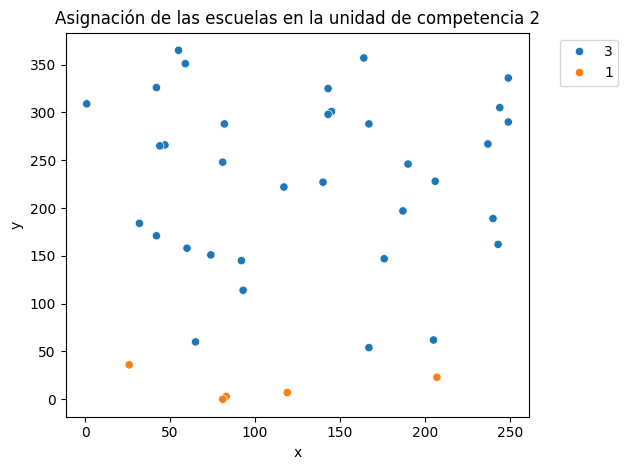

In [134]:
plot_UC(escuelas,J1,2,reparto) # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

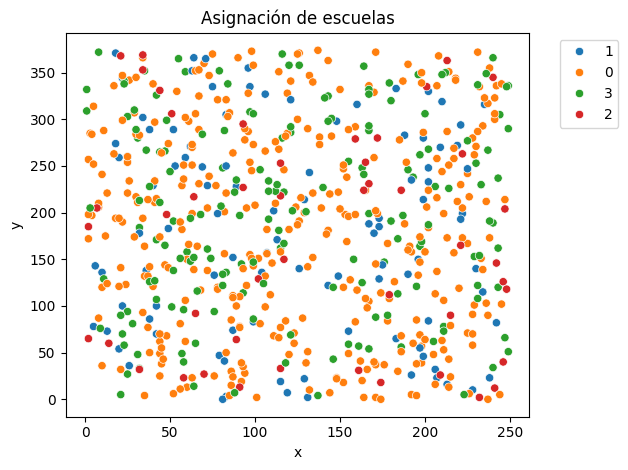

In [135]:
plot_reparto(escuelas, J1, reparto, sin_of, title="Asignación de escuelas") # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

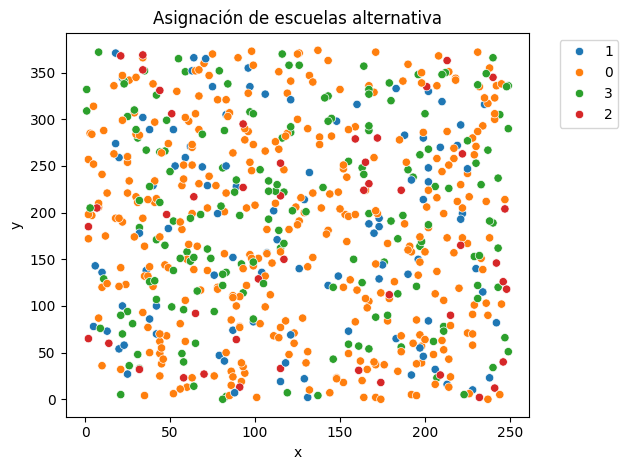

In [136]:
if reparto_alt is not None:
    plot_reparto(escuelas, J1, reparto_alt, sin_of, title="Asignación de escuelas alternativa") 
else:
    print("No hay una segunda mejor solución")

### Caso 2:

Primero definimos los precios por intervalo

In [24]:
T_min=list(range(0,100,20))+list(range(100,200,50))+list(range(200,701,100))
T_max= [T_min[i]-1 for i in range(1,len(T_min))]+[709]
costos=np.zeros([num_empresas,len(T_max)])

for i in range(num_empresas):
    costos[i,0]=np.random.rand()*1000 + 400
    for t in range(1,len(T_max)):
        descuento=1-(np.random.rand()/10)
        costos[i,t]= costos[i,t-1] * descuento
        

In [25]:
costos # vemos los costos definidos

array([[ 506.12754321,  499.739998  ,  475.50412809,  443.60788051,
         420.583756  ,  383.31002103,  367.04085532,  359.49084985,
         357.43090725,  333.36189706,  306.78986766,  297.8861067 ,
         297.8145595 ],
       [ 890.60955462,  847.82216586,  827.90586963,  754.73247981,
         715.22530484,  666.32061374,  617.78335512,  593.12040751,
         580.48760276,  563.12262556,  533.88356051,  495.68358366,
         452.45823202],
       [1237.15878379, 1184.25189646, 1115.59343861, 1025.67856582,
         962.20555634,  904.09347733,  846.80737338,  810.5711128 ,
         794.17901999,  774.11643586,  722.95337005,  709.91733876,
         655.3689018 ],
       [ 718.04146213,  665.78784998,  609.24098493,  590.22421276,
         589.72980334,  548.59877598,  504.06399426,  482.92405051,
         445.625335  ,  421.30324686,  407.74364629,  384.94325949,
         348.77507561]])

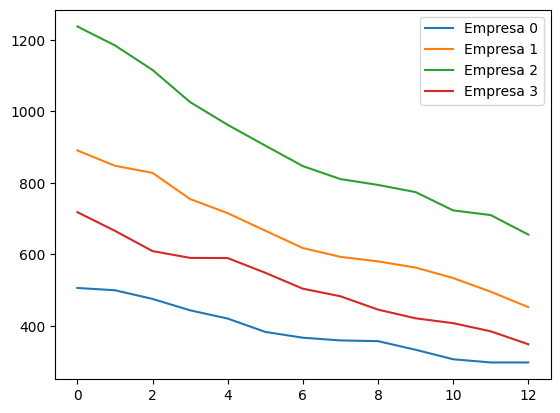

In [26]:
# comparamos los precios para las distintas empresas en distintos rangos
for i in range(num_empresas):
    plt.plot(range(0,len(T_max)),costos[i], label=f"Empresa {i}")
plt.legend()

Luego, veamos las unidades de competencia definidas

In [27]:
for i in range(num_empresas):
    plot_ofertas_de_empresa(escuelas, B1, i)

In [27]:
plot_unidades_competencia(escuelas, J1, sin_of)

Creamos el modelo y lo resolvemos. Nos fijamos si existe una solución alternativa

In [27]:
## creamos el modelo
model, sin_ofertantes = definir_modelo(B2,costos,nombre_modelo="Licitacion 2",T_max=T_max,T_min=T_min)

In [28]:
# obtenemos la solución
#model.redirectOutput()
model.optimize()
sol=model.getBestSol()
model.writeSol(sol,"solve2.xlsx")
valor_optimo=model.getObjVal()

In [29]:
modelo_alternativo, sin_ofertantes_alternativo = obtener_optimos_alternativos(B1,costos,model,sol,T_max=T_max,T_min=T_min)

Comparamos las soluciones

In [30]:
modelo_alternativo.optimize()
if round(modelo_alternativo.getObjVal(), 2) == round(valor_optimo, 2):
    sol_alternativa=modelo_alternativo.getBestSol()
else:
    print("No hay otra solución óptima.")
    sol_alternativa = None

No hay otra solución óptima.


In [31]:
modelo_alternativo.getObjVal() , valor_optimo

(329856.64955090726, 327796.46653287805)

In [32]:
reparto=filtrar_variables_ganadores(model,sol)
print(reparto)

if sol_alternativa is not None:
    reparto_alt=filtrar_variables_ganadores(modelo_alternativo,sol_alternativa)
    print()
    print(reparto_alt)
else:
    reparto_alt = None
    print("No hay solución alternativa")

{(1, 11): 53.0, (1, 14): 44.0, (0, 13): 46.0, (0, 1): 37.0, (0, 2): 43.0, (0, 4): 46.0, (0, 5): 32.0, (2, 0): 45.0, (0, 8): 46.0, (0, 9): 34.0, (3, 3): 38.0, (3, 5): 11.0, (3, 6): 43.0, (3, 7): 48.0, (3, 10): 60.0, (0, 12): 36.0, (1, 1): 3.0}
No hay solución alternativa


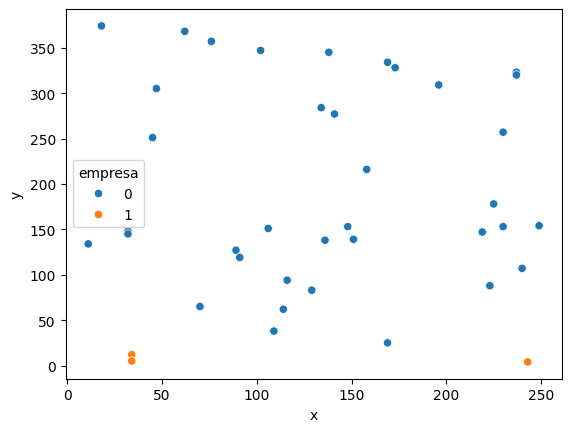

In [34]:
plot_UC(escuelas,J2,1,reparto) # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

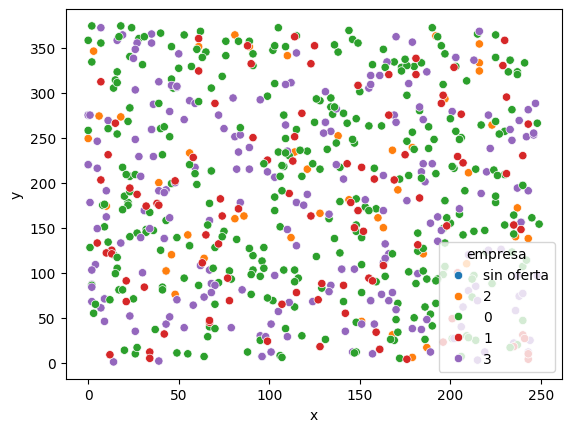

In [35]:
plot_reparto(escuelas, J2, reparto, sin_of) # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

In [36]:
if reparto_alt is not None:
    plot_reparto(escuelas, J2, reparto_alt, sin_of) 
else:
    print("No hay una segunda mejor solución")

No hay una segunda mejor solución


### Caso 3:

Primero definimos los precios por intervalo

In [37]:
T_min=list(range(0,100,20))+list(range(100,200,50))+list(range(200,701,100))
T_max= [T_min[i]-1 for i in range(1,len(T_min))]+[709]
costos=np.zeros([num_empresas,len(T_max)])

for i in range(num_empresas):
    costos[i,0]=np.random.rand()*1000 + 400
    for t in range(1,len(T_max)):
        descuento=1-(np.random.rand()/10)
        costos[i,t]= costos[i,t-1] * descuento
        

In [38]:
costos # vemos los costos definidos

array([[ 540.51581414,  538.41927794,  503.4759462 ,  460.45176399,
         426.37763006,  400.11656608,  399.03003933,  371.56830417,
         353.46878178,  351.51064013,  345.17134502,  339.1587713 ,
         335.13987226],
       [1002.66376407,  942.22253347,  895.91251002,  877.53937475,
         864.29459369,  783.32088499,  737.01493142,  665.18679992,
         632.50663522,  604.08460302,  589.09468153,  535.260351  ,
         491.66981246],
       [ 926.72798204,  851.00473893,  773.96919552,  709.26996445,
         661.92801406,  637.44918052,  592.88755333,  589.630563  ,
         589.10947065,  558.99236296,  504.08778397,  485.38289415,
         472.80309153],
       [ 756.09089077,  755.75209733,  712.18935932,  701.57071762,
         698.96153639,  630.59108363,  600.42102077,  570.3404299 ,
         531.89873338,  498.38939563,  491.69023896,  449.16736635,
         419.63412791]])

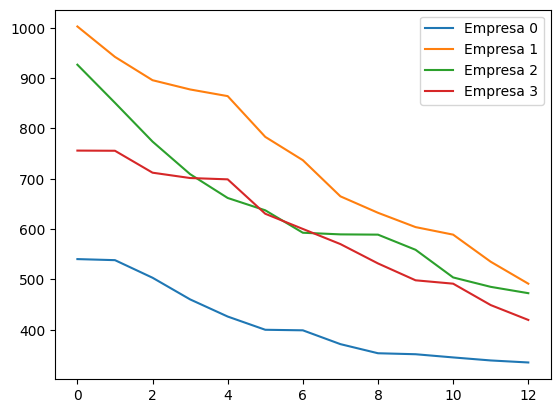

In [39]:
# comparamos los precios para las distintas empresas en distintos rangos
for i in range(num_empresas):
    plt.plot(range(0,len(T_max)),costos[i], label=f"Empresa {i}")
plt.legend()

Luego, veamos las unidades de competencia definidas

In [40]:
for i in range(num_empresas):
    plot_ofertas_de_empresa(escuelas, B1, i)

In [40]:
plot_unidades_competencia(escuelas, J1, sin_of)

Creamos el modelo y lo resolvemos. Nos fijamos si existe una solución alternativa

In [40]:
## creamos el modelo
model, sin_ofertantes = definir_modelo(B3,costos,nombre_modelo="Licitacion 3",T_max=T_max,T_min=T_min)

In [41]:
# obtenemos la solución
#model.redirectOutput()
model.optimize()
sol=model.getBestSol()
model.writeSol(sol,"solve3.xlsx")
valor_optimo=model.getObjVal()

In [42]:
modelo_alternativo, sin_ofertantes_alternativo = obtener_optimos_alternativos(B1,costos,model,sol,T_max=T_max,T_min=T_min)

Comparamos las soluciones

In [43]:
modelo_alternativo.optimize()
if round(modelo_alternativo.getObjVal(), 2) == round(valor_optimo, 2):
    sol_alternativa=modelo_alternativo.getBestSol()
else:
    print("No hay otra solución óptima.")
    sol_alternativa = None

No hay otra solución óptima.


In [44]:
modelo_alternativo.getObjVal() , valor_optimo

(329065.9041098471, 326946.5730219772)

In [45]:
reparto=filtrar_variables_ganadores(model,sol)
print(reparto)

if sol_alternativa is not None:
    reparto_alt=filtrar_variables_ganadores(modelo_alternativo,sol_alternativa)
    print()
    print(reparto_alt)
else:
    print("No hay solución alternativa")
    reparto_alt = None

{(1, 14): 1.0, (0, 0): 44.0, (0, 1): 48.0, (0, 2): 48.0, (2, 4): 32.0, (2, 12): 55.0, (2, 13): 44.0, (2, 14): 42.0, (0, 6): 40.0, (0, 7): 46.0, (0, 8): 48.0, (0, 9): 44.0, (0, 10): 37.0, (3, 3): 32.0, (3, 4): 26.0, (3, 11): 42.0, (1, 5): 39.0}
No hay solución alternativa


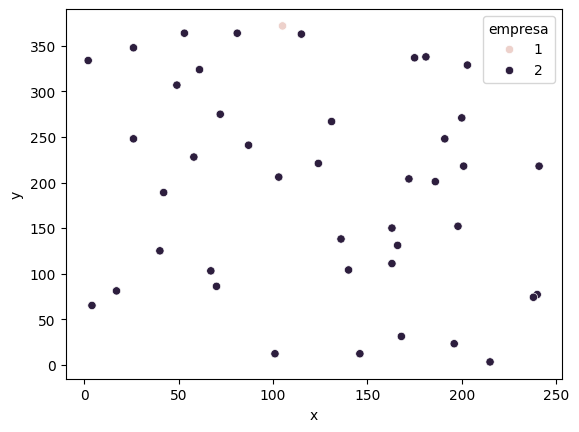

In [46]:
plot_UC(escuelas,J3,14,reparto) # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

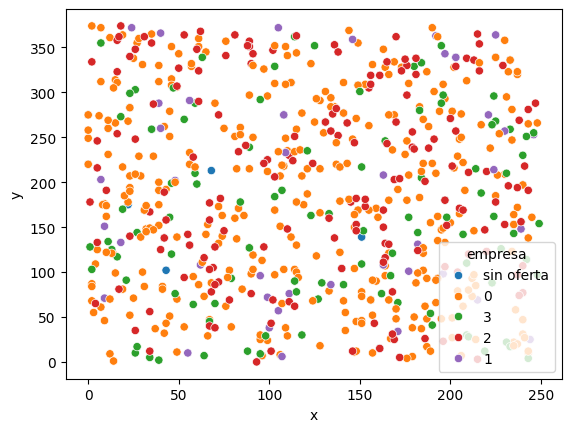

In [47]:
plot_reparto(escuelas, J3, reparto, sin_of) # puedo ver las escuelas de alguna de las unidades de competencia, por ejemplo, la segunda

In [48]:
if reparto_alt is not None:
    plot_reparto(escuelas, J1, reparto_alt, sin_of) 
else:
    print("No hay una segunda mejor solución")
    reparto_alt = None

No hay una segunda mejor solución
